In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import zipfile
import os


In [2]:
df = pd.read_csv('/content/Restaurant_Reviews.csv', delimiter=',')
df.head()


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


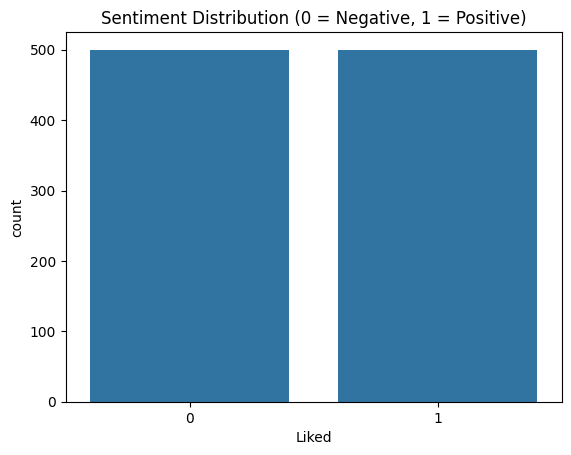

In [3]:
sns.countplot(x='Liked', data=df)
plt.title('Sentiment Distribution (0 = Negative, 1 = Positive)')
plt.show()


In [4]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Review'])
y = df['Liked']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       152
           1       0.82      0.79      0.81       148

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



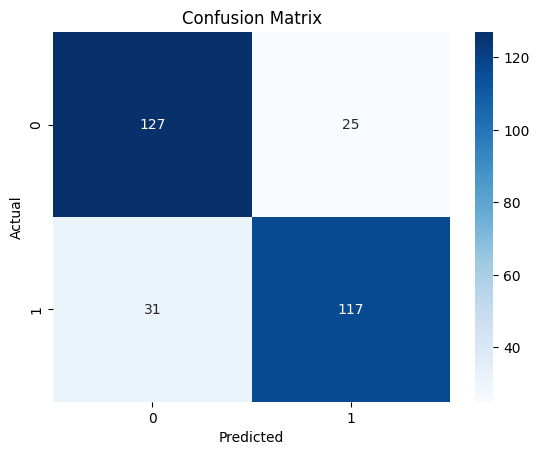

In [7]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import ipywidgets as widgets
from IPython.display import display

def predict_sentiment(review):
    # Transform the input review using the vectorizer
    input_vector = vectorizer.transform([review])

    # Predict sentiment
    prediction = model.predict(input_vector)[0]

    # Return the sentiment prediction
    return "Positive" if prediction == 1 else "Negative"

# Text input widget
review_input = widgets.Text(
    placeholder='Enter your review here...',
    description='Review:',
    disabled=False
)

# Button widgets for sample reviews
sample_reviews = [
    "The food was delicious and the service was excellent!",
    "Terrible experience, food was cold and service was slow."
]

sample_buttons = [widgets.Button(description=review) for review in sample_reviews]

def on_button_click(b):
    review_input.value = b.description

for button in sample_buttons:
    button.on_click(on_button_click)

# Output widget for displaying predictions
output = widgets.Output()

def update_output(change):
    output.clear_output()
    with output:
        prediction = predict_sentiment(change['new'])
        print(f"Predicted Sentiment: {prediction}")

review_input.observe(update_output, names='value')

# Display widgets
display(review_input)
display(widgets.HBox(sample_buttons))
display(output)


Text(value='', description='Review:', placeholder='Enter your review here...')

Output()

In [14]:
!pip install gradio


In [13]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
import io
import base64

# Assume the `vectorizer` and `model` are preloaded or defined elsewhere
def predict_sentiment(review):
    # Transform the input review using the vectorizer
    input_vector = vectorizer.transform([review])
    # Predict sentiment
    prediction = model.predict(input_vector)[0]
    # Return the sentiment prediction
    return prediction, "Positive" if prediction == 1 else "Negative"

# Sample reviews for buttons
sample_reviews = [
    "The food was delicious and the service was excellent!",
    "Terrible experience, food was cold and service was slow."
]

# Function to set the review text from a button
def set_review_text(review):
    return review

# Function to save user reviews and calculate percentages
user_reviews = []

def save_review(review, sentiment):
    user_reviews.append((review, sentiment))
    return "Your review has been saved!", display_user_reviews(), calculate_percentages()

# Function to display user reviews
def display_user_reviews():
    return "\n".join([f"Review: {r[0]} | Sentiment: {r[1]}" for r in user_reviews])

# Function to calculate and return the percentages of positive and negative reviews
def calculate_percentages():
    if not user_reviews:
        return "Positive Reviews: 0% \nNegative Reviews: 0%"

    total_reviews = len(user_reviews)
    positive_count = sum(1 for r in user_reviews if r[1] == "Positive")
    negative_count = total_reviews - positive_count

    positive_percentage = (positive_count / total_reviews) * 100
    negative_percentage = (negative_count / total_reviews) * 100

    overall_sentiment = "Overall Sentiment: Positive" if positive_percentage > 50 else "Overall Sentiment: Negative"

    return f"Positive Reviews: {positive_percentage:.2f}% \nNegative Reviews: {negative_percentage:.2f}%\n{overall_sentiment}"

# Gradio interface with enhanced styling
with gr.Blocks(css="""
    .gradio-container {
        background-color: #F0F8FF; /* Alice Blue */
        padding: 20px;
        border-radius: 15px;
        box-shadow: 0 4px 20px rgba(0, 0, 0, 0.2);
        font-family: 'Arial', sans-serif;
    }

    h1 {
        text-align: center;
        color: #1E90FF; /* Dodger Blue */
        margin-bottom: 20px;
        font-size: 2.5em;
    }

    #review-input, #sentiment-output {
        border: 2px solid #1E90FF; /* Dodger Blue */
        border-radius: 8px;
        padding: 15px;
        width: 100%;
        font-size: 1em;
    }

    #review-input {
        height: 100px;
        resize: none;
    }

    #sentiment-output {
        background-color: #e6f7ff; /* Light blue background */
    }

    .gr-button {
        margin: 5px;
        border-radius: 5px;
        background-color: #1E90FF; /* Dodger Blue */
        color: white;
        font-weight: bold;
        padding: 10px 20px;
        border: none;
        transition: background-color 0.3s, transform 0.3s;
    }

    .gr-button:hover {
        background-color: #1C86EE; /* Darker shade on hover */
        transform: scale(1.05);
    }

    .menu {
        display: flex;
        justify-content: center;
        padding: 10px;
        margin-bottom: 20px;
    }

    .menu a {
        margin: 0 15px;
        text-decoration: none;
        color: #1E90FF; /* Dodger Blue */
        font-weight: bold;
        font-size: 1.2em;
        transition: color 0.3s;
    }

    .menu a:hover {
        color: #1C86EE; /* Darker shade on hover */
    }

    .review-history, .sentiment-percentages {
        border: 2px solid #1E90FF; /* Dodger Blue */
        border-radius: 8px;
        padding: 10px;
        background-color: #f0f8ff; /* Alice Blue */
        margin-top: 15px;
    }

    .review-history {
        height: 150px;
        overflow-y: auto;
    }

    .sentiment-percentages {
        height: 80px;
    }
""") as demo:

    # Page 1: Restaurant Details
    with gr.Tab("Restaurant Details"):
        gr.Markdown("<h1>Welcome to FRCRCE Canteen!</h1>")
        restaurant_info = gr.Markdown("**Location:** Bandra, FRCRCE<br>**Cuisine:** Indian, Chinese, Italian")
        restaurant_image = gr.Image(value="/content/foood.jpg", label="Restaurant Image", height=200)



    # Page 2: User Reviews
    with gr.Tab("User Reviews"):
        gr.Markdown("<h1>Leave Your Review</h1>")
        review_input = gr.Textbox(
            label="Type your review here...",
            placeholder="Share your thoughts about our restaurant...",
            lines=3,
            elem_id="review-input"
        )

        with gr.Row():
            # Buttons for sample reviews
            sample_buttons = [gr.Button(review) for review in sample_reviews]

            for i, button in enumerate(sample_buttons):
                button.click(fn=lambda review=sample_reviews[i]: set_review_text(review), inputs=[], outputs=review_input)

        sentiment_output = gr.Textbox(
            label="Predicted Sentiment",
            interactive=False,
            elem_id="sentiment-output"
        )

        # Button to save the review
        save_button = gr.Button("Save Review")

        # Textbox for displaying user review history
        user_review_history = gr.Textbox(
            label="Your Review History",
            interactive=False,
            lines=4,
            elem_id="review-history"
        )

        # Textbox for displaying sentiment percentages
        sentiment_percentage_output = gr.Textbox(
            label="Sentiment Percentages",
            interactive=False,
            lines=4,
            elem_id="sentiment-percentages"
        )

        # Event to update output when the review input changes
        review_input.change(fn=predict_sentiment, inputs=review_input, outputs=sentiment_output)

        # Save review button action
        save_button.click(fn=lambda review: save_review(review, predict_sentiment(review)[1]),
                          inputs=review_input, outputs=[user_review_history, sentiment_output, sentiment_percentage_output])

# Launch the Gradio interface
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://61b6ec719f4bcf98ba.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
